In [13]:
import pandas as pd
import numpy as np
import os.path as op

In [66]:
# Data from participants (ag & gender)

df_participants = pd.read_csv('/Users/mrenke/data/ds-dnumrisk/add_tables/subjects_recruit&scan_scanned_march24.csv', header=1) #, index_col=0
df_participants = df_participants.loc[:,['subject ID', 'age','group','gender']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
df_participants.head()

,age,group,gender
subject,,,
1,19.0,0,w
2,17.0,1,w
3,15.0,0,w
4,17.0,1,w
5,20.0,0,w


In [24]:
# Normen für IDS-2
file_IDS2_screen_norms = '/Users/mrenke/Desktop/DNumRisk/addiMeasures/IDS-2_screener_normen.xlsx'
norms_mat = pd.read_excel(file_IDS2_screen_norms, 'ME') # matrix reasoning
norms_cat = pd.read_excel(file_IDS2_screen_norms, 'KN') # category naming

norms_mat.columns = [x for x in range(0, len(norms_mat.columns))] 
norms_mat.loc[0,0:5] = np.arange(15,21)
norms_mat = norms_mat.rename(mapper={6:'IQ'},axis=1)

norms_cat.columns = [x for x in range(0, len(norms_cat.columns))] 
norms_cat.loc[0,0:5] = np.arange(15,21)
norms_cat = norms_cat.rename(mapper={6:'IQ'},axis=1)
norms_cat = norms_cat.loc[:14,:]

In [74]:
# IDS-Screener results from participants (multiple files!)
bids_folder = '/Users/mrenke/data/ds-dnumrisk'
am1_cat = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_1.xlsx'), sheet_name='IDS - Kategorien')
am1_matrices = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_1.xlsx'), sheet_name='IDS- Matrizen')

am2_cat = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_2.xlsx'), sheet_name='Kategorien_nennen')
am2_matrices = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_2.xlsx'), sheet_name='Matrizen_ergänzen')

am3_cat = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_3.xlsx'), sheet_name='kategorien_nennen')
am3_matrices = pd.read_excel(op.join(bids_folder,'add_tables','add_measure_3.xlsx'), sheet_name='matrizen_ergänzen')



In [89]:
# 1.: select row with sub ID and mean score, 2.: transpose, 3.: drop NaNs and other row, 4.: rename columns, 5.: set index to subject ID
df_am1_cat =am1_cat.loc[[6,35],:].T.dropna(axis=0).rename(mapper={6:'subject',35:'cat_score'},axis=1).astype({'subject': int}).set_index('subject')
df_am1_matrices = am1_matrices.loc[[1,37], :].T.dropna(axis=0).rename(mapper={1:'subject',37:'mat_score'},axis=1).astype({'subject': int}).set_index('subject')
df_am2_cat = am2_cat.loc[[2,29],:].T.dropna(axis=0).drop('Unnamed: 2').rename(mapper={2:'subject',29:'cat_score'},axis=1).astype({'subject': int}).set_index('subject')
df_am2_matrices = am2_matrices.loc[[2,36], :].T.dropna(axis=0).rename(mapper={2:'subject',36:'mat_score'},axis=1).astype({'subject': int}).set_index('subject')
df_am3_cat =am3_cat.loc[[2,29],:].T.dropna(axis=0).drop('Unnamed: 2').rename(mapper={2:'subject',29:'cat_score'},axis=1).astype({'subject': int}).set_index('subject')
df_am3_matrices =am3_matrices.loc[[2,36],:].T.dropna(axis=0).drop('Unnamed: 2').rename(mapper={2:'subject',36:'mat_score'},axis=1).astype({'subject': int}).set_index('subject')

# join everyhting
df_scores= pd.concat([df_am1_cat,df_am2_cat, df_am3_cat]).join(pd.concat([df_am1_matrices,df_am2_matrices, df_am3_matrices]))
df_scores.sort_index(inplace=True)
df_scores.head()

,cat_score,mat_score
subject,,
1,29,25
2,26,18
3,23,23
4,28,22
5,31,15.0


In [88]:
subject_list= df_participants.reset_index()['subject'].unique()

iqs = []
for sub in subject_list:
    age = df_participants.loc[sub,'age']
    if age > 20:
        age = 20
    score_KN = df_scores.loc[sub,'cat_score']
    score_ME = df_scores.loc[sub,'mat_score']

    col = np.where(norms_mat.loc[0,:] == age)[0][0]
    row = np.where(norms_mat.loc[:,col] <= score_ME)[0].max()
    iq_ME = norms_mat.loc[row,'IQ']

    col = np.where(norms_cat.loc[0,:] == age)[0][0]
    row = np.where(norms_cat.loc[:,col] <= score_KN)[0].max()
    iq_KN = norms_cat.loc[row,'IQ']

    iqs.append([iq_ME, iq_KN])


In [93]:
df_comb = pd.concat([pd.DataFrame(iqs,columns=['me','kn']), df_participants.reset_index()], axis=1).set_index('subject')
df_comb['mean_iq'] = df_comb[['me','kn']].mean(axis=1)
df_comb.head()

,me,kn,age,group,gender,mean_iq
subject,,,,,,
1,120.0,105.0,19.0,0,w,112.5
2,100.0,95.0,17.0,1,w,97.5
3,115.0,95.0,15.0,0,w,105.0
4,110.0,105.0,17.0,1,w,107.5
5,90.0,115.0,20.0,0,w,102.5


In [118]:
df_comb.loc[46]

me         65.0
kn         55.0
age        23.0
group         1
gender        w
mean_iq    60.0
Name: 46, dtype: object

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=False, alternative=alternative)
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/effsize.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  d = (x.mean() - y.mean()) / poolsd
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/pingouin/parametric.py:280: RuntimeWarning: invalid value encountered in multiply
  ci = np.array([tval - tcrit, tval + tcrit]) * se


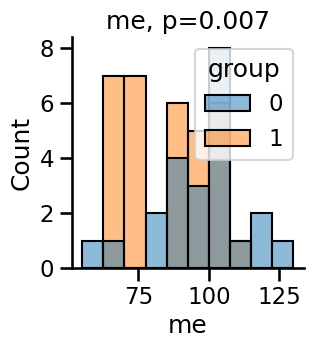

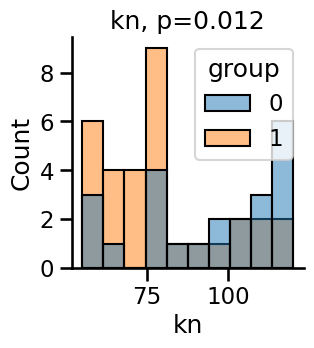

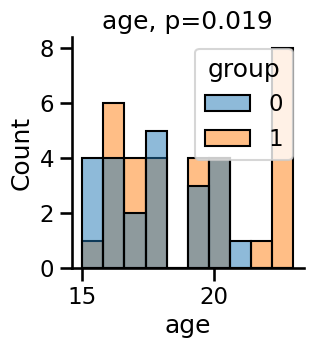

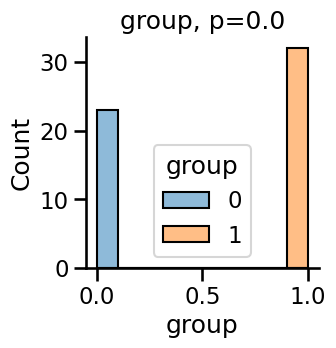

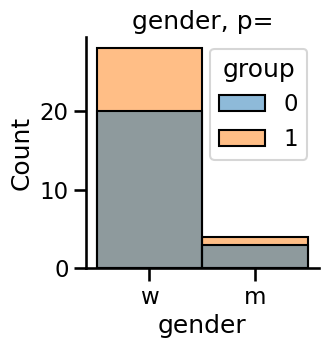

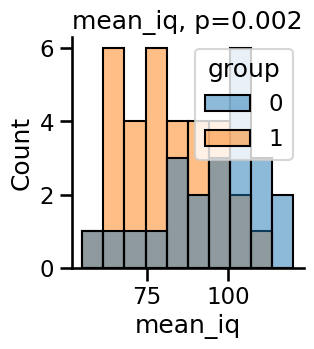

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
sns.set_context('talk')

var = 'age'#'kn'#'mean_iq''gender'# ['age','kn','me','mean_iq']
for var in df_comb.columns:
    plt.figure(figsize=(3,3))
    sns.histplot(data=df_comb, x=var,hue='group',bins=10)

    g0 = df_comb.loc[df_comb['group']==0][var]
    g1 = df_comb.loc[df_comb['group']==1][var]

    try: 
        pval = np.round(pg.ttest(g0,g1)['p-val'].values[0], 3)
    except:
        pval = ''
    plt.title(f'{var}, p={pval}')
    sns.despine()

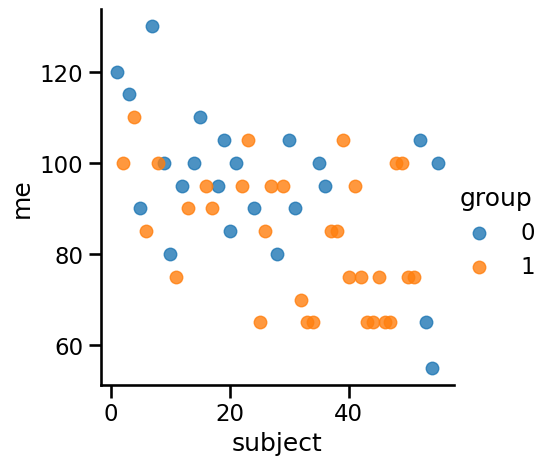

In [127]:
# plot over  subjects (effects of me as experminter, pratice effects etc. )
# but also just had 'dummer' subjects more recently than at the beginning....
sns.lmplot(data=df_comb.reset_index(), x='subject',y='me',hue='group',fit_reg=False)

In [11]:
import os
import nbformat

# Paths to look for
paths_to_find = [
    '/Users/mrenke/data/ds-dnumrisk/add_tables/subjects_recruit&scan.xlsx',
    '/Users/mrenke/Desktop/DNumRisk/addiMeasures/IDS-2_screener_normen.xlsx'
]

# Start from the root directory
root_dir = '/'

for dir_name, sub_dir_list, file_list in os.walk(root_dir):
    for file_name in file_list:
        if file_name.endswith('.ipynb'):
            file_path = os.path.join(dir_name, file_name)
            with open(file_path, 'r') as f:
                try:
                    nb = nbformat.read(f, as_version=4)
                    for cell in nb.cells:
                        if cell.cell_type == 'code':
                            for path in paths_to_find:
                                if path in cell.source:
                                    print(f'Found in {file_path}')
                except Exception as e:
                    print(f'Error reading file {file_path}: {e}')

Error reading file /usr/local/fsl/fslpython/pkgs/nbformat-5.4.0-pyhd8ed1ab_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /usr/local/fsl/fslpython/pkgs/nbformat-5.4.0-pyhd8ed1ab_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /usr/local/fsl/fslpython/pkgs/nbformat-5.4.0-pyhd8ed1ab_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to '7611188c'.
  validate(nb)


Error reading file /System/Volumes/Data/usr/local/fsl/fslpython/pkgs/nbformat-5.4.0-pyhd8ed1ab_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /System/Volumes/Data/usr/local/fsl/fslpython/pkgs/nbformat-5.4.0-pyhd8ed1ab_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /System/Volumes/Data/usr/local/fsl/fslpython/pkgs/nbformat-5.4.0-pyhd8ed1ab_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to 'a1962e88'.
  validate(nb)


Found in /System/Volumes/Data/Users/mrenke/Library/Application Support/Code/User/History/13d2a088/aBw4.ipynb
Found in /System/Volumes/Data/Users/mrenke/Library/Application Support/Code/User/History/13d2a088/oCPo.ipynb
Found in /System/Volumes/Data/Users/mrenke/Library/Application Support/Code/User/History/13d2a088/FbMH.ipynb
Found in /System/Volumes/Data/Users/mrenke/Library/Application Support/Code/User/History/13d2a088/4lHQ.ipynb
Found in /System/Volumes/Data/Users/mrenke/Library/Application Support/Code/User/History/13d2a088/dhCp.ipynb
Found in /System/Volumes/Data/Users/mrenke/Library/Application Support/Code/User/History/13d2a088/Ec9k.ipynb
Found in /System/Volumes/Data/Users/mrenke/Library/Application Support/Code/User/History/13d2a088/xAlN.ipynb
Found in /System/Volumes/Data/Users/mrenke/Library/Application Support/Code/User/History/2d160c3/Vdho.ipynb
Error reading file /System/Volumes/Data/Users/mrenke/mambaforge/pkgs/nbformat-5.7.0-py310hca03da5_0/info/test/tests/test3_workshe

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to 'aa8d82fb'.
  validate(nb)


Error reading file /System/Volumes/Data/Users/mrenke/mambaforge/pkgs/nbformat-5.3.0-py39hca03da5_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /System/Volumes/Data/Users/mrenke/mambaforge/pkgs/nbformat-5.3.0-py39hca03da5_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /System/Volumes/Data/Users/mrenke/mambaforge/pkgs/nbformat-5.3.0-py39hca03da5_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to 'adc8936b'.
  validate(nb)


Error reading file /System/Volumes/Data/Users/mrenke/mambaforge/pkgs/nbformat-5.9.2-py39hca03da5_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /System/Volumes/Data/Users/mrenke/mambaforge/pkgs/nbformat-5.9.2-py39hca03da5_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /System/Volumes/Data/Users/mrenke/mambaforge/pkgs/nbformat-5.9.2-py39hca03da5_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to '556074be'.
  validate(nb)


Error reading file /System/Volumes/Data/Users/mrenke/mambaforge/pkgs/nbformat-5.7.0-py39hca03da5_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /System/Volumes/Data/Users/mrenke/mambaforge/pkgs/nbformat-5.7.0-py39hca03da5_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /System/Volumes/Data/Users/mrenke/mambaforge/pkgs/nbformat-5.7.0-py39hca03da5_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to 'f82340c6'.
  validate(nb)


Error reading file /System/Volumes/Data/Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py37hecd8cb5_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /System/Volumes/Data/Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py37hecd8cb5_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /System/Volumes/Data/Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py37hecd8cb5_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to 'd3346a11'.
  validate(nb)


Error reading file /System/Volumes/Data/Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py310hecd8cb5_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /System/Volumes/Data/Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py310hecd8cb5_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /System/Volumes/Data/Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py310hecd8cb5_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to '1d15abe2'.
  validate(nb)


Found in /System/Volumes/Data/Users/mrenke/git/numrisk/numrisk/prepare/demographics_IQ_balanceGroups.ipynb
Error reading file /System/Volumes/Data/Users/mrenke/git/stress_risk/stress_risk/prepare/check_files_sciencecluster2.ipynb: Notebook does not appear to be JSON: '{\n "cells": [\n  {\n   "cell_type": "c...
Error reading file /System/Volumes/Data/Users/mrenke/git/stress_risk/stress_risk/prepare/check_all_files_scloud.ipynb: Notebook does not appear to be JSON: '{\n "cells": [\n  {\n   "cell_type": "c...
Error reading file /System/Volumes/Data/Users/mrenke/git/stress_risk/stress_risk/fmri_analysis/glm/glm_fit_debug.ipynb: Notebook does not appear to be JSON: ''
Error reading file /System/Volumes/Data/Users/mrenke/git/bauer/notebooks/test_riskmodel.ipynb: Notebook does not appear to be JSON: ''
Found in /Users/mrenke/Library/Application Support/Code/User/History/13d2a088/aBw4.ipynb
Found in /Users/mrenke/Library/Application Support/Code/User/History/13d2a088/oCPo.ipynb
Found in /Users

/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to 'bbcda51c'.
  validate(nb)


Error reading file /Users/mrenke/mambaforge/pkgs/nbformat-5.3.0-py39hca03da5_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /Users/mrenke/mambaforge/pkgs/nbformat-5.3.0-py39hca03da5_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /Users/mrenke/mambaforge/pkgs/nbformat-5.3.0-py39hca03da5_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to 'fe493c44'.
  validate(nb)


Error reading file /Users/mrenke/mambaforge/pkgs/nbformat-5.9.2-py39hca03da5_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /Users/mrenke/mambaforge/pkgs/nbformat-5.9.2-py39hca03da5_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /Users/mrenke/mambaforge/pkgs/nbformat-5.9.2-py39hca03da5_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to '90bc6d4f'.
  validate(nb)


Error reading file /Users/mrenke/mambaforge/pkgs/nbformat-5.7.0-py39hca03da5_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /Users/mrenke/mambaforge/pkgs/nbformat-5.7.0-py39hca03da5_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /Users/mrenke/mambaforge/pkgs/nbformat-5.7.0-py39hca03da5_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to '308c0328'.
  validate(nb)


Error reading file /Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py37hecd8cb5_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py37hecd8cb5_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py37hecd8cb5_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to '858bf88d'.
  validate(nb)


Error reading file /Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py310hecd8cb5_0/info/test/tests/test3_worksheet_with_no_cells.ipynb: The notebook is invalid and is missing an expected key: cells
Error reading file /Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py310hecd8cb5_0/info/test/tests/test3_no_metadata.ipynb: Notebook could not be converted from version 3 to version 4 because it's missing a key: metadata
Error reading file /Users/mrenke/opt/anaconda3/pkgs/nbformat-5.3.0-py310hecd8cb5_0/info/test/tests/test3_no_worksheets.ipynb: The notebook is invalid and is missing an expected key: worksheets


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/nbformat/__init__.py:93: DuplicateCellId: Non-unique cell id 'dup' detected. Corrected to '9611f72f'.
  validate(nb)


Found in /Users/mrenke/git/numrisk/numrisk/prepare/demographics_IQ_balanceGroups.ipynb
Error reading file /Users/mrenke/git/stress_risk/stress_risk/prepare/check_files_sciencecluster2.ipynb: Notebook does not appear to be JSON: '{\n "cells": [\n  {\n   "cell_type": "c...
Error reading file /Users/mrenke/git/stress_risk/stress_risk/prepare/check_all_files_scloud.ipynb: Notebook does not appear to be JSON: '{\n "cells": [\n  {\n   "cell_type": "c...
Error reading file /Users/mrenke/git/stress_risk/stress_risk/fmri_analysis/glm/glm_fit_debug.ipynb: Notebook does not appear to be JSON: ''
Error reading file /Users/mrenke/git/bauer/notebooks/test_riskmodel.ipynb: Notebook does not appear to be JSON: ''
